In [1]:
#XY Python Code for SPH6004 Group Assignment
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from datetime import datetime


In [2]:
#collapse_data = pd.read_csv("/Users/xueying/Downloads/SPH6004/Assignment 2 question (group assi/Data From Maxine/OneDrive_1_4-8-2022/TimeSeries_Collapsed_v1_all_data_dummy.csv")
collapse_data = pd.read_csv("/Users/xueying/Downloads/SPH6004/Assignment 2 question (group assi/Data From Maxine/Updated Summarised Class/TimeSeries_Collapsed_v1_all_data.csv")
collapse_data.head()
collapse_data.shape

(21164, 96)

In [3]:
time_to_aki_hr=[]
for i in range(0,collapse_data.shape[0]):
    if (pd.isnull(collapse_data['aki_charttime'][i])):
        time_to_aki_hr.append(float("nan"))
    else:
        icu_intime=datetime.strptime(collapse_data['icu_intime'][i], '%m/%d/%Y %H:%M')
        aki_time=datetime.strptime(collapse_data['aki_charttime'][i], '%m/%d/%Y %H:%M')
        time_to_aki_hr.append((aki_time-icu_intime).total_seconds()/3600)

collapse_data['time_to_aki_hr']=time_to_aki_hr

In [ ]:
#calculate the max of time to aki, replace censoring observations with duration = 2*max(time_to_aki)
time_to_aki_wona=pd.DataFrame(time_to_aki_hr).dropna()
max_time_to_aki_hr=max(time_to_aki_wona[0])

collapse_data['time_to_aki_hr'] = collapse_data['time_to_aki_hr'].replace(np.nan, 2*max_time_to_aki_hr)
collapse_data=collapse_data.drop(columns=['specimen', 'aki_charttime', 'icu_intime'])

collapse_data.head()

In [5]:
#print(collapse_data.isna().sum()/collapse_data.shape[0]*100)
#collapse_data.drop(columns='specimen')

collapse_data_wo_idntime=collapse_data.iloc[:,2:collapse_data.shape[1]]
collapse_data_wo_idntime=collapse_data_wo_idntime.drop(columns='time_to_aki_hr')
collapse_data_wo_idntime=collapse_data_wo_idntime.dropna()
print(collapse_data_wo_idntime.shape)
collapse_data_wo_idntime.head(10)

(21164, 91)


aado2_new  baseexcess  bicarbonate  calcium  carboxyhemoglobin  \
0  118.200000        -6.0         23.0  1.08000                1.0   
1  231.960989        -0.5         23.0  1.12625                1.0   
2  231.960989        -7.0         23.0  1.12625                1.0   
3  107.775000         3.5         23.0  1.12625                1.0   
4  231.960989        -0.5         23.0  1.12625                1.0   
5  231.960989        -2.0         23.0  1.12625                1.0   
6  231.960989        -3.5         23.0  1.09000                1.0   
7  231.960989        -0.5         23.0  1.12625                1.0   
8  163.275000        -1.0         23.0  1.12625                1.0   
9  146.200000        -3.0         23.0  1.12625                1.0   

     chloride  dbp_avg_new   fio2_new  glucose_new  heart_rate_avg  ...  \
0  105.226656    77.000000  40.000000   140.000000      108.500000  ...   
1  105.226656    72.548611  60.779488   156.500000       70.375000  ...   
2  105.226656    71.263889  60.779488   164.333333       82.493056  ...   
3  105.226656    50.754167  42.500000    99.333333       62.975992  ...   
4  105.226656    75.250000  60.779488   126.000000       76.125000  ...   
5  105.226656    34.888889  60.779488    95.000000       60.796296  ...   
6  107.000000    50.861111  60.779488   146.500000       67.833333  ...   
7  105.226656    67.430556  60.779488   146.000000       80.208333  ...   
8  105.226656    71.000000  67.500000   111.000000       75.666667  ...   
9  105.226656    55.021104  40.000000    96.000000       78.537879  ...   

   mild_liver_disease  diabetes_without_cc  diabetes_with_cc  paraplegia  \
0                   0                    0                 0           1   
1                   0                    0                 0           0   
2                   0                    1                 0           0   
3                   0                    0                 0           0   
4                   0                    0                 0           0   
5                   0                    0                 0           0   
6                   0                    0                 0           0   
7                   0                    0                 0           0   
8                   1                    1                 0           0   
9                   0                    0                 0           0   

   renal_disease  malignant_cancer  severe_liver_disease  \
0              0                 0                     0   
1              0                 1                     0   
2              0                 0                     0   
3              0                 1                     0   
4              0                 0                     0   
5              1                 0                     0   
6              0                 1                     0   
7              1                 0                     0   
8              0                 0                     0   
9              1                 0                     0   

   metastatic_solid_tumor  aids  charlson_comorbidity_index  
0                       0     0                           6  
1                       1     0                           9  
2                       0     0                           7  
3                       0     0                           5  
4                       0     0                           1  
5                       0     0                           9  
6                       0     0                           6  
7                       0     0                           8  
8                       0     0                           4  
9                       0     0                           6  

[10 rows x 91 columns]

In [6]:
column_list=list(collapse_data_wo_idntime.columns)

binary_var_list = collapse_data_wo_idntime.columns[collapse_data_wo_idntime.isin([0,1]).all()]
continuous_var_list=list(set(column_list) - set(binary_var_list))
print (continuous_var_list)
X_continuous=collapse_data_wo_idntime[continuous_var_list]
X_binary=collapse_data_wo_idntime[binary_var_list]
X_continuous

['charlson_comorbidity_index', 'chloride', 'age_score', 'pco2', 'sbp_avg_new', 'weight', 'fio2_new', 'potassium', 'aado2_new', 'heart_rate_avg', 'temperature_new', 'calcium', 'spo2_avg', 'hematocrit', 'adm_age', 'totalco2', 'ph', 'dbp_avg_new', 'bicarbonate', 'methemoglobin', 'glucose_new', 'lactate', 'hemoglobin', 'carboxyhemoglobin', 'pao2fio2ratio', 'so2', 'sodium', 'po2', 'baseexcess', 'mbp_ni_avg']


charlson_comorbidity_index    chloride  age_score  pco2  sbp_avg_new  \
0                               6  105.226656          3  28.0   102.500000   
1                               9  105.226656          3  41.0   117.680556   
2                               7  105.226656          3  46.0   120.694444   
3                               5  105.226656          3  35.0    90.842361   
4                               1  105.226656          1  41.0   122.625000   
...                           ...         ...        ...   ...          ...   
21159                           8  105.226656          4  41.5   104.600000   
21160                           8  105.226656          4  76.0   134.541667   
21161                           5  105.226656          2  37.0   104.583333   
21162                           9  105.226656          4  32.0    91.681818   
21163                           5  105.226656          3  41.0   115.250000   

       weight   fio2_new  potassium   aado2_new  heart_rate_avg  ...  \
0        80.0  40.000000       4.24  118.200000      108.500000  ...   
1        56.7  60.779488       4.24  231.960989       70.375000  ...   
2       106.9  60.779488       4.24  231.960989       82.493056  ...   
3        62.7  42.500000       4.24  107.775000       62.975992  ...   
4       118.0  60.779488       4.24  231.960989       76.125000  ...   
...       ...        ...        ...         ...             ...  ...   
21159    82.0  52.500000       3.60  253.700000       92.500000  ...   
21160    66.9  60.779488       4.24  231.960989       81.687500  ...   
21161   106.8  60.779488       4.24  231.960989      117.708333  ...   
21162    80.3  60.779488       4.24  231.960989       83.833333  ...   
21163    74.9  60.779488       4.24  231.960989       68.833333  ...   

       glucose_new  lactate  hemoglobin  carboxyhemoglobin  pao2fio2ratio  \
0       140.000000      3.0        10.4                1.0     330.000000   
1       156.500000      1.8        10.4                1.0     239.071429   
2       164.333333      1.8        10.4                1.0     239.071429   
3        99.333333      1.2        10.4                1.0     344.571429   
4       126.000000      1.8        10.4                1.0     239.071429   
...            ...      ...         ...                ...            ...   
21159   124.500000      1.6        10.4                1.0     130.666667   
21160   128.500000      1.8        10.4                1.0     239.071429   
21161   137.500000      1.3        10.4                1.0     239.071429   
21162   184.125000      1.8        10.4                1.0     239.071429   
21163   108.000000      1.8        10.4                1.0     239.071429   

             so2      sodium         po2  baseexcess  mbp_ni_avg  
0      96.666667  135.447096  132.000000       -6.00   83.000000  
1      96.666667  135.447096  142.894987       -0.50   85.916667  
2      96.666667  135.447096  147.000000       -7.00   82.666667  
3      96.666667  135.447096  151.500000        3.50   60.037500  
4      96.666667  135.447096  142.894987       -0.50   89.062500  
...          ...         ...         ...         ...         ...  
21159  85.500000  136.000000   68.750000       -1.75   79.849658  
21160  96.666667  135.447096  228.000000       23.00   82.041667  
21161  96.666667  135.447096   56.000000        0.00   76.625000  
21162  96.666667  135.447096  189.000000        4.00   60.590909  
21163  96.666667  135.447096  142.894987       -0.50   82.725000  

[21164 rows x 30 columns]

In [7]:
X_continuous_std=X_continuous.apply(lambda x: (x-x.mean()) / x.std(), axis=0)
X_continuous_std

X_feature_select_df = pd.concat([X_continuous_std, X_binary] , axis = 1)
X_orig_df = pd.concat([X_continuous, X_binary] , axis = 1)

column_list=list(X_feature_select_df.columns)

Y_feature_select_df = collapse_data['output']
Y_orig_df =collapse_data[['time_to_aki_hr', 'output']]

X_feature_select=torch.tensor(X_feature_select_df.to_numpy()).type(torch.float32)
Y_feature_select=torch.tensor(Y_feature_select_df.to_numpy()).type(torch.float32)
Y_feature_select = Y_feature_select.reshape(-1,1)

print(X_feature_select_df.shape)
print(Y_feature_select_df.shape)

#splitting strategy: 80% train, 20% test
observ_num = X_feature_select.shape[0]
observ_shuffled = torch.randperm(observ_num)

train_proportion = 0.8
train_list = observ_shuffled[:int(train_proportion*observ_num)]
test_list = observ_shuffled[int(train_proportion*observ_num):]

x_train_feature, x_test_feature = X_feature_select[train_list], X_feature_select[test_list]
y_train_feature, y_test_feature = Y_feature_select[train_list], Y_feature_select[test_list]

x_train_feature.shape

#column_list

(21164, 91)
(21164,)


torch.Size([16931, 91])

In [8]:
#Implement Elastic Net Rregression to perform feature selection
nIter = 1000 # We perform 1000 iterations of GD steps
loss_record = []

inputSize, outputSize = x_train_feature.shape[1], 1


model_elastic = nn.Sequential(nn.Linear(inputSize, outputSize), # innner product
                      nn.Sigmoid())               # sigmoid

# binary cross entrophy loss
J = nn.BCELoss()


#lambda parameter for L1 norm regularization
lbd=0.025

optimizer = SGD(model_elastic.parameters(),
                lr = 0.05,
                weight_decay=0.025, 
                momentum = 0.5)

#L1 norm regurlarization, sum up the absolute value of every parameters
def L1Norm(model):
     result = torch.tensor(0)
     for param in model.parameters(): 
        result = result + param.abs().sum()

     return result


for i in range(nIter):
    #print(i)
    optimizer.zero_grad()
    hat_y = model_elastic(x_train_feature)
    #print(hat_y)
    loss = J(hat_y,y_train_feature)
    (loss + lbd*L1Norm(model_elastic)).backward() 
    optimizer.step()
    loss_record.append(loss.item())
    if i%100 == 99 or i==0:
        print('At iteration {} loss is {:.4f}'.format(i+1,loss.item()))
        
#check the thetas after optimization 
params=torch.tensor(0)
for param in model_elastic.parameters(): 
    params=param.abs()
    break
    print(param.abs())
print(params)

At iteration 1 loss is 0.6779
At iteration 100 loss is 0.6138
At iteration 200 loss is 0.6093
At iteration 300 loss is 0.6081
At iteration 400 loss is 0.6079
At iteration 500 loss is 0.6075
At iteration 600 loss is 0.6076
At iteration 700 loss is 0.6076
At iteration 800 loss is 0.6075
At iteration 900 loss is 0.6076
At iteration 1000 loss is 0.6074
tensor([[1.4172e-01, 5.3091e-04, 4.9029e-02, 8.5529e-04, 9.1606e-02, 3.2061e-01,
         7.6655e-04, 1.4927e-03, 2.3073e-03, 6.3747e-02, 1.9625e-03, 1.0378e-03,
         8.6770e-02, 8.1786e-04, 1.4244e-01, 9.8514e-04, 1.6693e-03, 1.7882e-01,
         7.0832e-04, 2.3612e-04, 3.5430e-02, 5.5017e-02, 3.6674e-04, 1.0204e-03,
         4.9845e-04, 3.4594e-04, 5.8830e-06, 1.5520e-02, 1.0131e-03, 1.1442e-03,
         2.4779e-03, 4.0712e-04, 1.6790e-03, 3.6672e-05, 1.2304e-03, 9.8100e-04,
         6.7285e-04, 8.0914e-04, 2.7944e-04, 1.3230e-03, 3.5539e-03, 1.8679e-03,
         1.1364e-04, 1.2124e-03, 4.7220e-04, 5.0469e-04, 1.0383e-03, 1.1178e-03,
 

In [9]:
#print(column_list)
params_list=params.tolist()[0]
reduced_feature=list()
dropped_feature=list()
#Based on the output of parameters after elastic regularization, drop those feature with coefficient<0.001
for i in range(0, len(params_list)):
    if params_list[i]< 0.0001:
        #print(params_list[i])
        dropped_feature.append(column_list[i])
    else:
        reduced_feature.append(column_list[i])
        
print(len(dropped_feature))
print(len(reduced_feature))
#left with 12 features
print(reduced_feature)

3
88
['charlson_comorbidity_index', 'chloride', 'age_score', 'pco2', 'sbp_avg_new', 'weight', 'fio2_new', 'potassium', 'aado2_new', 'heart_rate_avg', 'temperature_new', 'calcium', 'spo2_avg', 'hematocrit', 'adm_age', 'totalco2', 'ph', 'dbp_avg_new', 'bicarbonate', 'methemoglobin', 'glucose_new', 'lactate', 'hemoglobin', 'carboxyhemoglobin', 'pao2fio2ratio', 'so2', 'po2', 'baseexcess', 'mbp_ni_avg', 'ace inhibitor', 'acetaminophen', 'alpha adrenergic agonist', 'angiotensin receptor blocker', 'angiotensin receptor neprilysin inhibitor', 'anti-arrhythmic', 'anti-diuretics', 'antibiotics', 'anticoagulant', 'anticonvulsant', 'antidepressant', 'antiemetics', 'antifungals', 'antihypertensive alpha blocker', 'antioxidant', 'antiplatelet', 'antipsychotic', 'antivirals', 'benzodiazepine', 'beta blocker', 'ca supplement', 'calcium channel blocker', 'chemotherapy', 'diuretics', 'fibrates', 'gout medications', 'h2 receptor blocker', 'hmg-coa reductase inhibitors', 'immunosuppressant', 'metformin', 

In [140]:
#X_reduced_orig is X original value, X_reduced_std is standardized x value
X_reduced_orig=X_orig_df[reduced_feature]
#X_reduced_orig=torch.tensor(X_reduced_orig.to_numpy()).type(torch.float32)

X_reduced_std=X_feature_select_df[reduced_feature]
#X_reduced_std=torch.tensor(X_reduced_std.to_numpy()).type(torch.float32)
print(X_reduced_std.shape, X_reduced_orig.shape)
print(Y_orig_df.shape)



(21164, 88) (21164, 88)
(21164, 2)


In [141]:
XY_concat_orig= pd.concat([X_reduced_orig, Y_orig_df] , axis = 1)
XY_concat_std=pd.concat([X_reduced_std, Y_orig_df] , axis = 1)
#X.head()
print(XY_concat_orig.shape)
XY_concat_orig.head()

print(XY_concat_orig.isnull().values.any())
print(XY_concat_std.isnull().values.any())
XY_concat_std.head()

(21164, 90)
False
False


charlson_comorbidity_index      chloride  age_score      pco2  sbp_avg_new  \
0                    0.147964 -4.389259e-09   0.124249 -1.767778    -0.957828   
1                    1.141986 -4.389259e-09   0.124249 -0.090754    -0.021448   
2                    0.479305 -4.389259e-09   0.124249  0.554255     0.164457   
3                   -0.183377 -4.389259e-09   0.124249 -0.864765    -1.676904   
4                   -1.508741 -4.389259e-09  -1.400166 -0.090754     0.283539   

     weight      fio2_new  potassium     aado2_new  heart_rate_avg  ...  \
0 -0.043131 -1.877347e+00   0.003319 -1.412006e+00        1.548576  ...   
1 -0.952475  1.009502e-10   0.003319 -1.456064e-11       -0.849415  ...   
2  1.006713  1.009502e-10   0.003319 -1.456064e-11       -0.087212  ...   
3 -0.718309 -1.651482e+00   0.003319 -1.541402e+00       -1.314799  ...   
4  1.439919  1.009502e-10   0.003319 -1.456064e-11       -0.487751  ...   

   diabetes_without_cc  diabetes_with_cc  paraplegia  renal_disease  \
0                    0                 0           1              0   
1                    0                 0           0              0   
2                    1                 0           0              0   
3                    0                 0           0              0   
4                    0                 0           0              0   

   malignant_cancer  severe_liver_disease  metastatic_solid_tumor  aids  \
0                 0                     0                       0     0   
1                 1                     0                       1     0   
2                 0                     0                       0     0   
3                 1                     0                       0     0   
4                 0                     0                       0     0   

   time_to_aki_hr  output  
0            3.35       1  
1           28.60       1  
2           96.00       0  
3           96.00       0  
4           96.00       0  

[5 rows x 90 columns]

In [142]:
XY_test=XY_concat_std.sample(frac=0.2)
XY_train=XY_concat_std.drop(XY_test.index)
XY_val = XY_train.sample(frac=0.2)
XY_train = XY_train.drop(XY_val.index)
print(XY_test.shape, XY_train.shape)

column_list=list(XY_concat_std.columns)
x_col=column_list[0:len(column_list)-2]
y_col=column_list[len(column_list)-2:len(column_list)]
#print(column_list[0:len(column_list)-2])
#print(column_list[len(column_list)-2:len(column_list)])
#print(x_col, y_col)

x_train=XY_train[x_col]
x_test=XY_test[x_col]
y_train=XY_train[y_col]
y_test=XY_test[y_col]

x_val=XY_val[x_col]
y_val=XY_val[y_col]
#print(y_train)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4233, 90) (13545, 90)
(13545, 88) (13545, 2) (4233, 88) (4233, 2)


In [143]:
y_train_fr_plot=y_train
y_test_fr_plot=y_test

y_train_fr_plot['output_TF']=np.where(y_train_fr_plot['output']==1, True, False)
y_test_fr_plot['output_TF']=np.where(y_test_fr_plot['output']==1, True, False)

y_train_fr_plot=y_train_fr_plot[['output_TF', 'time_to_aki_hr']]
y_test_fr_plot=y_test_fr_plot[['output_TF', 'time_to_aki_hr']]

y_train_fr_plot

output_TF  time_to_aki_hr
0           True        3.350000
2          False       96.000000
5          False       96.000000
6           True        6.333333
7          False       96.000000
...          ...             ...
21155      False       96.000000
21157      False       96.000000
21159       True       15.716667
21160      False       96.000000
21162      False       96.000000

[13545 rows x 2 columns]

# Logistic Hazard Model(time discrete)

In [17]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt


import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.models import LogisticHazard
from pycox.models import DeepHitSingle
from pycox.models import CoxCC
from pycox.evaluation import EvalSurv

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

import sksurv
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

from sksurv.metrics import (
  concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    
)

In [19]:
va_times = np.arange(2, 50, 4)

In [144]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['time_to_aki_hr'].values, df['output'].values)

y_train_transform = labtrans.fit_transform(*get_target(y_train))
y_test_transform=labtrans.transform(*get_target(y_test))
y_val_transform=labtrans.transform(*get_target(y_val))

x_train_float=x_train.astype('float32')
x_val_float=x_val.astype('float32')
x_test_float=x_test.astype('float32')
#x_train_np=x_train.to_numpy()


train = (x_train, y_train_transform)
test = (x_test, y_test_transform)
val=(x_val_float.to_numpy(), y_val_transform)
type(y_train_transform)

durations_test, events_test =y_test['time_to_aki_hr'], y_test['output']
val_fr_CoxNN = tt.tuplefy(x_val, y_val)


In [193]:
plt.rcParams['figure.figsize'] = [13, 10]

In [571]:
in_features = x_train.shape[1]
num_nodes =[32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

np.random.seed(1234)
_ = torch.manual_seed(123)
#net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
#net

In [314]:
first_layer=torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
)
hidden_layer=torch.nn.Sequential(
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    )

In [315]:
nn_32_2layer = torch.nn.Sequential(
    first_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [296]:
nn_32_4layer = torch.nn.Sequential(
    first_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [297]:
nn_32_6layer = torch.nn.Sequential(
    first_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [302]:
nn_32_8layer = torch.nn.Sequential(
    first_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [316]:
nn_32_10layer = torch.nn.Sequential(
    first_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [328]:
nn_32_15layer = torch.nn.Sequential(
    first_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [329]:
nn_32_20layer = torch.nn.Sequential(
    first_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [318]:
first_layer64=torch.nn.Sequential(
    torch.nn.Linear(in_features, 64),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(64),
    torch.nn.Dropout(0.1),
)
hidden_layer64=torch.nn.Sequential(
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(64),
    torch.nn.Dropout(0.1),
    )

In [320]:
nn_64_2layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    torch.nn.Linear(64, out_features)
)

In [321]:
nn_64_4layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    torch.nn.Linear(64, out_features)
)

In [322]:
nn_64_6layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    torch.nn.Linear(64, out_features)
)

In [323]:
nn_64_8layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    torch.nn.Linear(64, out_features)
)

In [324]:
nn_64_10layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    torch.nn.Linear(64, out_features)
)

In [330]:
nn_64_15layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    torch.nn.Linear(64, out_features)
)

In [331]:
nn_64_20layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    torch.nn.Linear(64, out_features)
)

In [445]:
first_layer6432=torch.nn.Sequential(
    torch.nn.Linear(in_features, 64),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(64),
    torch.nn.Dropout(0.1),
)
hidden_layer6432=torch.nn.Sequential(
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    )

In [446]:
nn_64_32_2layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer6432,
    torch.nn.Linear(32, out_features)
)

In [447]:
nn_64_32_4layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer6432,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [448]:
nn_64_32_6layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer6432,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [449]:
nn_64_32_8layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer6432,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [450]:
nn_64_32_10layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer6432,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [451]:
nn_64_32_15layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer6432,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [452]:
nn_64_32_20layer = torch.nn.Sequential(
    first_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer64,
    hidden_layer6432,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    hidden_layer,
    torch.nn.Linear(32, out_features)
)

In [355]:
def LogisticHazard_Model_Result_NN(net):
    
    model_logisticHazard = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
    callbacks = [tt.cb.EarlyStopping()]
    
    #find the best learning rate
    lrfinder = model_logisticHazard.lr_finder(x_train_float.to_numpy(), y_train_transform, batch_size, tolerance=2)
    #_ = lrfinder.plot()
    lr_best=lrfinder.get_best_lr()
    # to prevent using a learning rate larger than 0.01
    if lr_best>0.01:
        model_logisticHazard.optimizer.set_lr(0.01)
    else:
        model_logisticHazard.optimizer.set_lr(lr_best)
        
    model_logisticHazard.fit(x_train_float.to_numpy(), y_train_transform, batch_size, epochs, callbacks,val_data=val)

    surv_logisticHazard = model_logisticHazard.predict_surv_df(x_test_float.to_numpy())

    durations_test=y_test['time_to_aki_hr'].to_numpy()
    events_test=y_test['output'].to_numpy()
    ev_logisticHazard = EvalSurv(surv_logisticHazard, durations_test, events_test, censor_surv='km')
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

    brier=ev_logisticHazard.integrated_brier_score(time_grid) 
    
    row_index_logisticHazard=np.asarray(surv_logisticHazard.index)
    cumulative_hazard_LogisticHazard=-np.log(surv_logisticHazard)

    step_functions=list()

    for i in range(0,cumulative_hazard_LogisticHazard.shape[1]):

        stpfun=sksurv.functions.StepFunction(row_index_logisticHazard, np.asarray(cumulative_hazard_LogisticHazard.iloc[:,i]), a=1.0, b=0.0)
        step_functions.append(stpfun)

    #risk_score=stpfun(va_times)
    logisticHazard_risk_scores = np.row_stack([chf(va_times) for chf in step_functions])

    logisticHazard_auc, logisticHazard_mean_auc = cumulative_dynamic_auc(
        y_train_fr_plot.to_records(index=False), y_test_fr_plot.to_records(index=False), logisticHazard_risk_scores, va_times
    )
    
    net.apply(weight_reset)
    return (brier, logisticHazard_auc, logisticHazard_mean_auc)

In [350]:
def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

In [352]:
def train_w_NNlist(NN_list):
    #brier_list=[]
    mean_auc_list=[]
    for net in NN_list:
        brier,_,mean_auc=LogisticHazard_Model_Result_NN(net)
        #brier_list.append(brier)
        mean_auc_list.append(mean_auc)
    return mean_auc_list


In [ ]:
NN_list_32=[nn_32_2layer,nn_32_4layer,nn_32_6layer,nn_32_8layer, nn_32_10layer,nn_32_15layer,nn_32_20layer]
NN_list_64=[nn_64_2layer,nn_64_4layer, nn_64_6layer, nn_64_8layer, nn_64_10layer, nn_64_15layer, nn_64_20layer]
#NN_list_128=[nn_128_2layer,nn_128_4layer,nn_128_6layer,nn_128_8layer,nn_128_10layer,nn_128_15layer,nn_128_20layer]
NN_list_64_32=[nn_64_32_2layer, nn_64_32_4layer, nn_64_32_6layer, nn_64_32_8layer, nn_64_32_10layer, nn_64_32_15layer,nn_64_32_20layer]

mean_auc_list_32_loop=[]
mean_auc_list_64_loop=[]
mean_auc_list_128_loop=[]
mean_auc_list_64_32_loop=[]

for i in range(0,10):
    print(i)
    #mean_auc_list_32=train_w_NNlist(NN_list_32)
    #mean_auc_list_64=train_w_NNlist(NN_list_64)
    mean_auc_list_64_32=train_w_NNlist(NN_list_64_32)
    
    #mean_auc_list_32_loop.append(mean_auc_list_32)
    #mean_auc_list_64_loop.append(mean_auc_list_64)
    mean_auc_list_64_32_loop.append(mean_auc_list_64_32)
    

In [378]:
#print(mean_auc_list)
#number of hidden layers
NN_list_frplt=['2','4','6','8', '10','15','20']


[0.6801183134758617, 0.6808652460094005, 0.7159764347759261, 0.697153096029584, 0.6267895538322632, 0.5523352509024985, 0.48881870898194046, 0.6489606140430618, 0.7821645147953677, 0.6858396670097957, 0.7258473299606103, 0.7971908432723043, 0.5604562922868886, 0.5236191924680549]


In [387]:
mean_auc_list_32_loop
mean_auc_list_32_loop_df = pd.DataFrame (mean_auc_list_32_loop, columns = ['2layer', '4layer', '6layer', '8layer', '10layer','15layer','20layer'])
overall_mean_auc_32_loop=mean_auc_list_32_loop_df.mean()

In [390]:
mean_auc_list_64_loop
mean_auc_list_64_loop_df = pd.DataFrame (mean_auc_list_64_loop, columns = ['2layer', '4layer', '6layer', '8layer', '10layer','15layer','20layer'])
overall_mean_auc_64_loop=mean_auc_list_64_loop_df.mean()

In [492]:
mean_auc_list_64_32_loop
mean_auc_list_64_32_loop_df = pd.DataFrame (mean_auc_list_64_32_loop, columns = ['2layer', '4layer', '6layer', '8layer', '10layer','15layer','20layer'])
overall_mean_auc_64_32_loop=mean_auc_list_64_32_loop_df.mean()

In [494]:
overall_mean_auc_LogH_df=pd.concat([overall_mean_auc_32_loop, overall_mean_auc_64_loop,overall_mean_auc_64_32_loop], axis=1)
overall_mean_auc_LogH_df.columns=['All Layers 32 Nodes', 'All Layers 64 Nodes', 'Half 64 Nodes Half 32 Nodes']
overall_mean_auc_LogH_df

All Layers 32 Nodes  All Layers 64 Nodes  Half 64 Nodes Half 32 Nodes
2layer              0.740479             0.743212                     0.711868
4layer              0.748536             0.758918                     0.761114
6layer              0.754883             0.764772                     0.776644
8layer              0.770509             0.726244                     0.752740
10layer             0.522154             0.617238                     0.588833
15layer             0.513073             0.510927                     0.501574
20layer             0.489663             0.501191                     0.480015

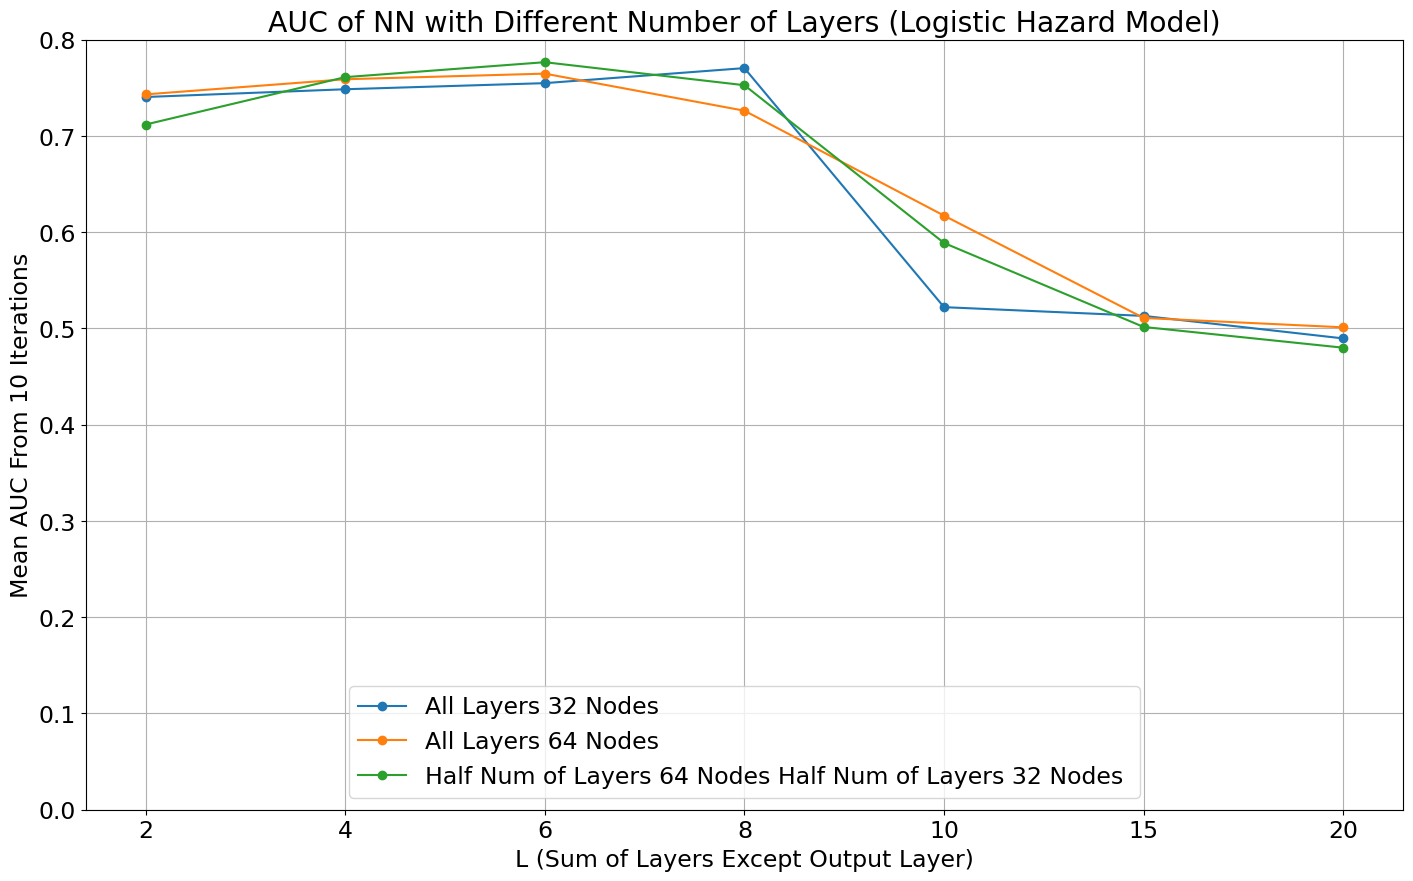

In [553]:
plt.rcParams['figure.figsize'] = [17, 10]
plt.rcParams.update({'font.size': 17})

plt.plot(NN_list_frplt, overall_mean_auc_32_loop, "o-", label="All Layers 32 Nodes")
plt.plot(NN_list_frplt, overall_mean_auc_64_loop, "o-", label="All Layers 64 Nodes")
plt.plot(NN_list_frplt, overall_mean_auc_64_32_loop, "o-", label="Half Num of Layers 64 Nodes Half Num of Layers 32 Nodes ")


plt.xlabel("L (Sum of Layers Except Output Layer)")
plt.ylabel("Mean AUC From 10 Iterations")
plt.ylim(0,0.8)
plt.legend(loc="lower center")
plt.title('AUC of NN with Different Number of Layers (Logistic Hazard Model)')
plt.grid(True)
# plt.savefig('/Users/xueying/Downloads/SPH6004/Assignment 2 question (group assi/AUC_allmodels_10fold.png')

In [ ]:
model_logisticHazard = LogisticHazard(nn_64_32_6layer, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

lrfinder = model_logisticHazard.lr_finder(x_train_float.to_numpy(), y_train_transform, batch_size, tolerance=2)
_ = lrfinder.plot()
lr_best=lrfinder.get_best_lr()

model_logisticHazard.optimizer.set_lr(lr_best)

log = model_logisticHazard.fit(x_train_float.to_numpy(), y_train_transform, batch_size, epochs, callbacks,val_data=val)
_ = log.plot()

In [181]:
plt.rcParams['figure.figsize'] = [5, 3]


In [ ]:
#predictions of the test_set
surv_logisticHazard = model_logisticHazard.predict_surv_df(x_test_float.to_numpy())
surv_logisticHazard.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('Survival Estimate')
_ = plt.xlabel('Time')
#print(surv_logisticHazard)
row_index_logisticHazard=np.asarray(surv_logisticHazard.index)
print(surv_logisticHazard.index)

In [ ]:
surv_logisticHazard_interpolate = model_logisticHazard.interpolate(10).predict_surv_df(x_test_float.to_numpy())
surv_logisticHazard_interpolate.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('Survival Estimate')
_ = plt.xlabel('Time')

In [ ]:
durations_test=y_test['time_to_aki_hr'].to_numpy()
events_test=y_test['output'].to_numpy()
ev_logisticHazard = EvalSurv(surv_logisticHazard, durations_test, events_test, censor_surv='km')
ev_logisticHazard.concordance_td('antolini')
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev_logisticHazard.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')
ev_logisticHazard.integrated_brier_score(time_grid) 

In [400]:
row_index_logisticHazard=np.asarray(surv_logisticHazard.index)
row_index_logisticHazard


array([ 0.        , 10.66666667, 21.33333333, 32.        , 42.66666667,
       53.33333333, 64.        , 74.66666667, 85.33333333, 96.        ])

In [401]:
cumulative_hazard_LogisticHazard=-np.log(surv_logisticHazard)
cumulative_hazard_LogisticHazard.shape
cumulative_hazard_LogisticHazard

0         1         2         3         4         5     \
0.000000   0.001554  0.002434  0.001563  0.001904  0.000782  0.005139   
10.666667  0.166973  1.023978  0.244655  0.787104  0.073223  0.124815   
21.333333  0.379312  1.863695  0.535287  1.407217  0.189868  1.286888   
32.000000  0.540640  2.201996  0.745552  1.729235  0.306417  1.723445   
42.666667  0.625081  2.480642  0.875523  1.964649  0.371394  1.865607   
53.333333  0.649124  2.581832  0.910118  2.032633  0.382531  1.983185   
64.000000  0.651336  2.592937  0.913450  2.039842  0.383659  1.998301   
74.666667  0.653086  2.596600  0.915587  2.042697  0.385268  2.007333   
85.333333  0.655368  2.607582  0.919103  2.050354  0.386318  2.018596   
96.000000  0.656538  2.622657  0.921333  2.057712  0.387442  2.025498   

               6         7         8         9     ...      4223      4224  \
0.000000   0.001705  0.001559  0.003736  0.001435  ...  0.001791  0.002240   
10.666667  0.234154  0.496123  0.185398  0.441688  ...  0.593901  0.130034   
21.333333  0.509756  0.880802  1.084053  0.879130  ...  1.200132  0.703766   
32.000000  0.695944  1.110658  1.460035  1.145838  ...  1.543916  1.050934   
42.666667  0.799348  1.263669  1.639485  1.311607  ...  1.793620  1.196795   
53.333333  0.828091  1.303289  1.729397  1.354767  ...  1.863854  1.251415   
64.000000  0.830751  1.306570  1.741741  1.358331  ...  1.873002  1.259001   
74.666667  0.832788  1.308254  1.748476  1.360079  ...  1.876453  1.263634   
85.333333  0.835998  1.312861  1.758656  1.363936  ...  1.884221  1.270035   
96.000000  0.837736  1.315461  1.766600  1.366868  ...  1.892363  1.273789   

               4225      4226      4227      4228      4229      4230  \
0.000000   0.000324  0.001039  0.001002  0.001200  0.001749  0.001802   
10.666667  0.024065  0.092205  0.064626  0.094976  0.527171  0.857622   
21.333333  0.065546  0.211326  0.161140  0.249177  0.978849  1.442990   
32.000000  0.106603  0.302345  0.238915  0.372371  1.248402  1.759884   
42.666667  0.129064  0.359895  0.290374  0.440720  1.432811  1.995236   
53.333333  0.136887  0.379961  0.312944  0.460803  1.481490  2.057869   
64.000000  0.137545  0.381314  0.314272  0.462652  1.486379  2.063457   
74.666667  0.137832  0.382265  0.315152  0.464091  1.488617  2.065524   
85.333333  0.138181  0.383362  0.316107  0.465751  1.494393  2.071948   
96.000000  0.138316  0.384052  0.316761  0.466737  1.498375  2.078046   

               4231      4232  
0.000000   0.000462  0.001704  
10.666667  0.034651  0.139046  
21.333333  0.089393  0.416432  
32.000000  0.141116  0.622079  
42.666667  0.170363  0.721132  
53.333333  0.180689  0.748296  
64.000000  0.181557  0.751444  
74.666667  0.182000  0.754181  
85.333333  0.182499  0.757260  
96.000000  0.182728  0.759019  

[10 rows x 4233 columns]

In [402]:
step_functions=list()

for i in range(0,cumulative_hazard_LogisticHazard.shape[1]):
    
    stpfun=sksurv.functions.StepFunction(row_index_logisticHazard, np.asarray(cumulative_hazard_LogisticHazard.iloc[:,i]), a=1.0, b=0.0)
    step_functions.append(stpfun)

#risk_score=stpfun(va_times)
logisticHazard_risk_scores = np.row_stack([chf(va_times) for chf in step_functions])


In [403]:
logisticHazard_auc, logisticHazard_mean_auc = cumulative_dynamic_auc(
    y_train_fr_plot.to_records(index=False), y_test_fr_plot.to_records(index=False), logisticHazard_risk_scores, va_times
)

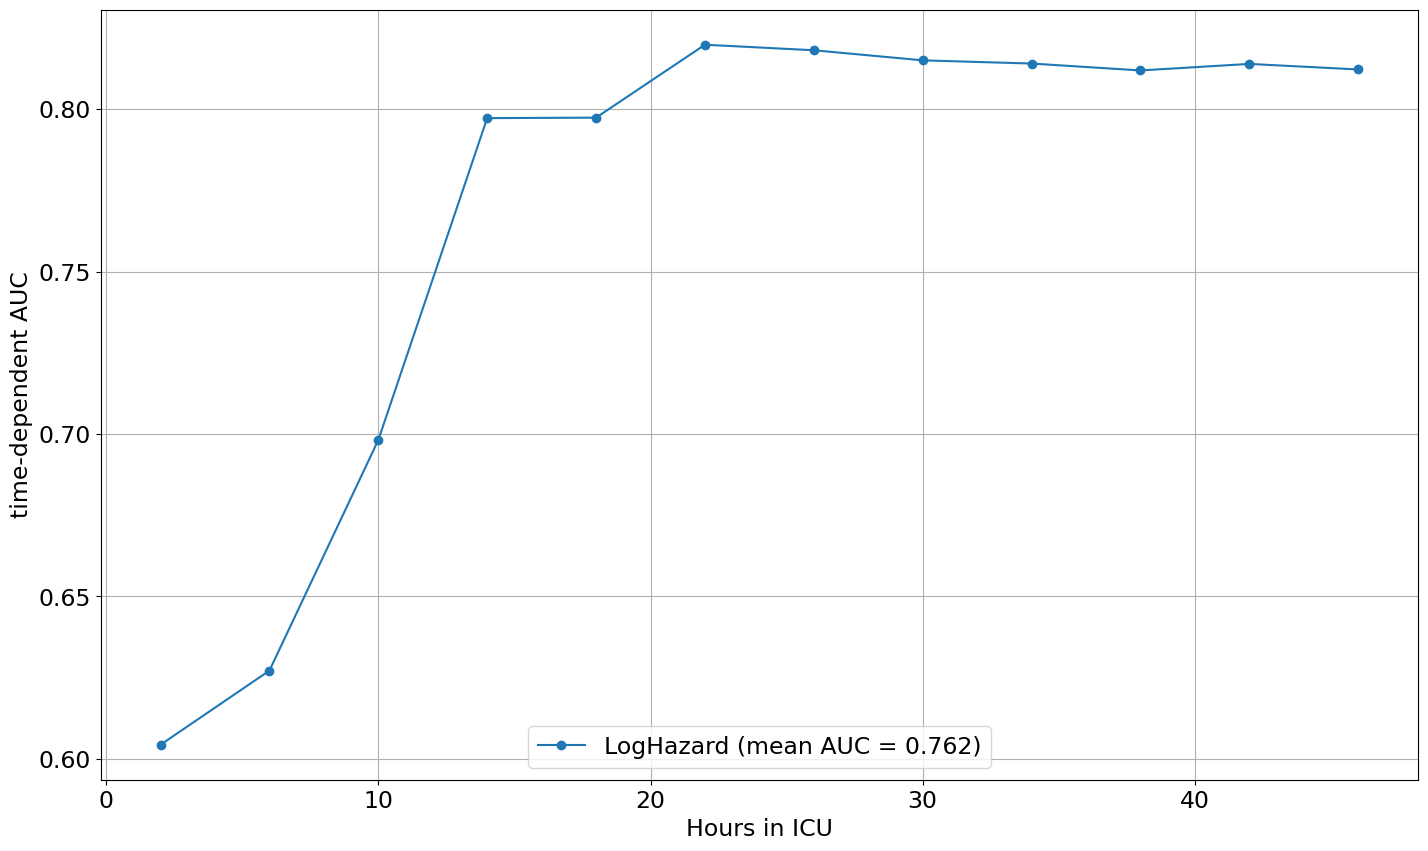

In [404]:
plt.plot(va_times, logisticHazard_auc, "o-", label="LogHazard (mean AUC = {:.3f})".format(logisticHazard_mean_auc))
plt.xlabel("Hours in ICU")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

# Deep Hit for Single Event (time discrete)

In [198]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)


In [405]:
def DeepHS_Model_Result_NN(net):
    from pycox.models import DeepHitSingle
    model_DeepHS = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
    callbacks = [tt.cb.EarlyStopping()]
    
    
    #find the best learning rate
    lrfinder = model_DeepHS.lr_finder(x_train_float.to_numpy(), y_train_transform, batch_size, tolerance=2)
    #_ = lrfinder.plot()
    lr_best=lrfinder.get_best_lr()
    # to prevent using a learning rate larger than 0.01
    if lr_best>0.01:
        model_DeepHS.optimizer.set_lr(0.01)
    else:
        model_DeepHS.optimizer.set_lr(lr_best)
        
    model_DeepHS.fit(x_train_float.to_numpy(), y_train_transform, batch_size, epochs, callbacks,val_data=val)

    surv_DeepHitSingle = model_DeepHS.predict_surv_df(x_test_float.to_numpy())

    durations_test=y_test_fold['time_to_aki_hr'].to_numpy()
    events_test=y_test_fold['output'].to_numpy()
    ev_DeepHitSingle = EvalSurv(surv_DeepHitSingle, durations_test, events_test, censor_surv='km')
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

    brier=ev_DeepHitSingle.integrated_brier_score(time_grid) 
    
    row_index_DeepHitSingle=np.asarray(surv_DeepHitSingle.index)
    cumulative_hazard_DeepHitSingle=-np.log(surv_DeepHitSingle)

    step_functions=list()

    for i in range(0,cumulative_hazard_DeepHitSingle.shape[1]):

        stpfun=sksurv.functions.StepFunction(row_index_DeepHitSingle, np.asarray(cumulative_hazard_DeepHitSingle.iloc[:,i]), a=1.0, b=0.0)
        step_functions.append(stpfun)

    #risk_score=stpfun(va_times)
    DeepHitSingle_risk_scores = np.row_stack([chf(va_times) for chf in step_functions])
    DeepHitSingle_auc, DeepHitSingle_mean_auc = cumulative_dynamic_auc(
        y_train_fr_plot.to_records(index=False), y_test_fr_plot.to_records(index=False), DeepHitSingle_risk_scores, va_times
    )
    
    net.apply(weight_reset)
    return (brier, DeepHitSingle_auc, DeepHitSingle_mean_auc)

In [407]:
def train_w_NNlist_DeepHS(NN_list):
    #brier_list=[]
    mean_auc_list=[]
    for net in NN_list:
        brier,_,mean_auc=DeepHS_Model_Result_NN(net)
        #brier_list.append(brier)
        mean_auc_list.append(mean_auc)
    return mean_auc_list

In [ ]:
NN_list_32=[nn_32_2layer,nn_32_4layer,nn_32_6layer,nn_32_8layer, nn_32_10layer,nn_32_15layer,nn_32_20layer]
NN_list_64=[nn_64_2layer,nn_64_4layer, nn_64_6layer, nn_64_8layer, nn_64_10layer, nn_64_15layer, nn_64_20layer]
#NN_list_128=[nn_128_2layer,nn_128_4layer,nn_128_6layer,nn_128_8layer,nn_128_10layer,nn_128_15layer,nn_128_20layer]
NN_list_64_32=[nn_64_32_2layer, nn_64_32_4layer, nn_64_32_6layer, nn_64_32_8layer, nn_64_32_10layer, nn_64_32_15layer,nn_64_32_20layer]
mean_auc_list_32_loop=[]
mean_auc_list_64_loop=[]
mean_auc_list_128_loop=[]
mean_auc_list_64_32_loop=[]

for i in range(0,10):
    print(i)
    #mean_auc_list_32=train_w_NNlist_DeepHS(NN_list_32)
    #mean_auc_list_64=train_w_NNlist_DeepHS(NN_list_64)
    #mean_auc_list_128=train_w_NNlist_DeepHS(NN_list_128)
    mean_auc_list_64_32=train_w_NNlist_DeepHS(NN_list_64_32)
    
    #mean_auc_list_32_loop.append(mean_auc_list_32)
    #mean_auc_list_64_loop.append(mean_auc_list_64)
    mean_auc_list_64_32_loop.append(mean_auc_list_64_32)
    

In [409]:
mean_auc_list_32_loop
mean_auc_list_32_loop_df = pd.DataFrame (mean_auc_list_32_loop, columns = ['2layer', '4layer', '6layer', '8layer', '10layer','15layer','20layer'])
overall_mean_auc_32_loop_DeepHS=mean_auc_list_32_loop_df.mean()

In [425]:
mean_auc_list_64_loop
mean_auc_list_64_loop_df = pd.DataFrame (mean_auc_list_64_loop, columns = ['2layer', '4layer', '6layer', '8layer', '10layer','15layer','20layer'])
overall_mean_auc_64_loop_DeepHS=mean_auc_list_64_loop_df.mean()

In [461]:
mean_auc_list_64_32_loop
mean_auc_list_64_32_loop_df = pd.DataFrame (mean_auc_list_64_32_loop, columns = ['2layer', '4layer', '6layer', '8layer', '10layer','15layer','20layer'])
overall_mean_auc_64_32_loop_DeepHS=mean_auc_list_64_32_loop_df.mean()

In [489]:
overall_mean_auc_DeepHit_df=pd.concat([overall_mean_auc_32_loop_DeepHS, overall_mean_auc_64_loop_DeepHS,overall_mean_auc_64_32_loop_DeepHS], axis=1)
overall_mean_auc_DeepHit_df.columns=['All Layers 32 Nodes', 'All Layers 64 Nodes', 'Half 64 Nodes Half 32 Nodes']

In [490]:
overall_mean_auc_DeepHit_df

All Layers 32 Nodes  All Layers 64 Nodes  Half 64 Nodes Half 32 Nodes
2layer              0.687573             0.719417                     0.681274
4layer              0.732461             0.694813                     0.718543
6layer              0.712727             0.696573                     0.723900
8layer              0.640070             0.663752                     0.708905
10layer             0.475034             0.618364                     0.682626
15layer             0.487895             0.639261                     0.679027
20layer             0.522678             0.580531                     0.711748

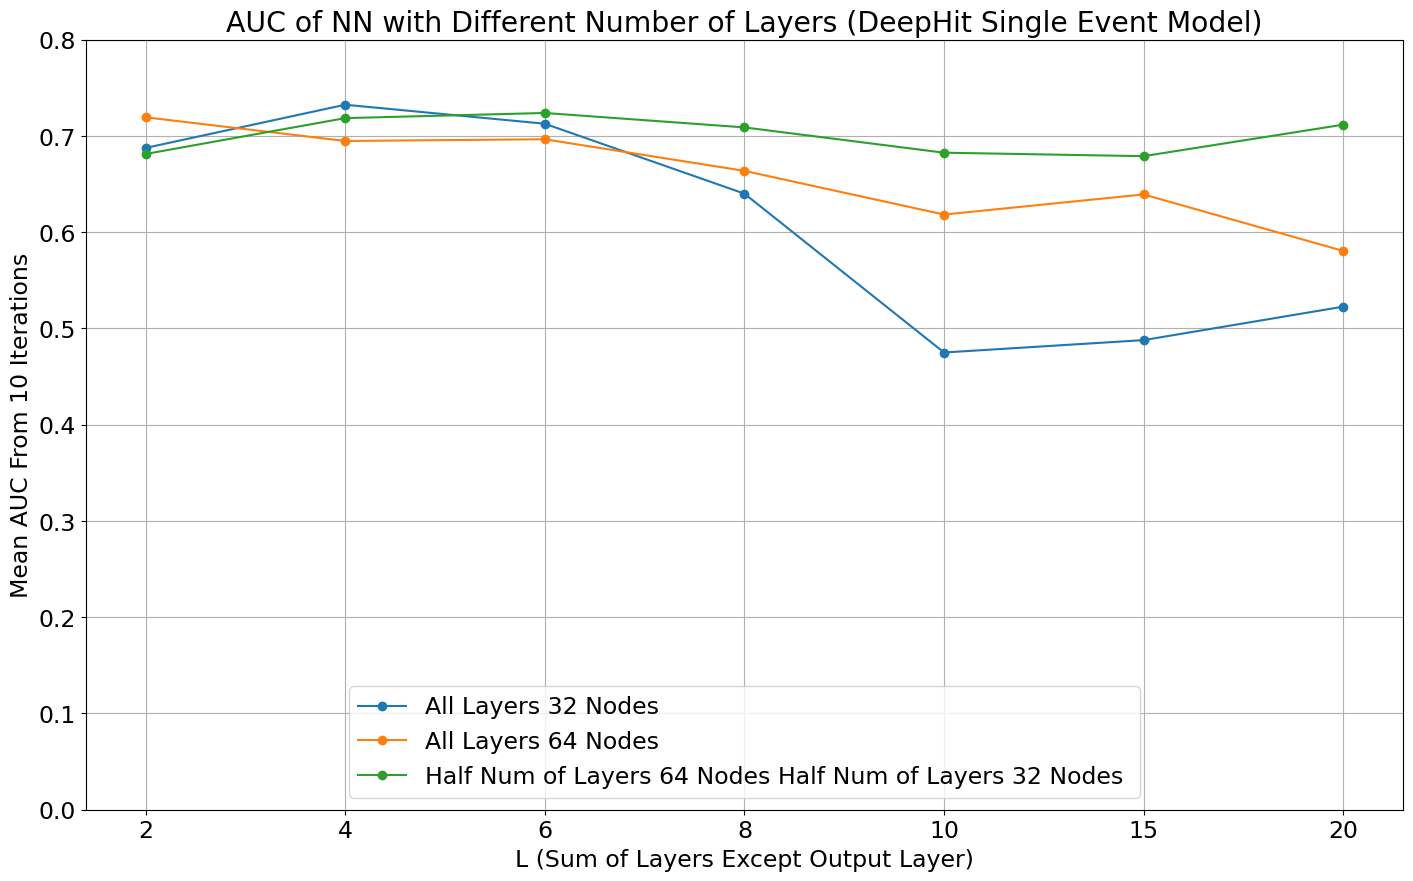

In [554]:
plt.rcParams['figure.figsize'] = [17, 10]
plt.rcParams.update({'font.size': 17})

plt.plot(NN_list_frplt, overall_mean_auc_32_loop_DeepHS, "o-", label="All Layers 32 Nodes")
plt.plot(NN_list_frplt, overall_mean_auc_64_loop_DeepHS, "o-", label="All Layers 64 Nodes")
plt.plot(NN_list_frplt, overall_mean_auc_64_32_loop_DeepHS, "o-", label="Half Num of Layers 64 Nodes Half Num of Layers 32 Nodes ")


plt.xlabel("L (Sum of Layers Except Output Layer)")
plt.ylabel("Mean AUC From 10 Iterations")
plt.ylim(0,0.8)
plt.legend(loc="lower center")
plt.title('AUC of NN with Different Number of Layers (DeepHit Single Event Model)')
plt.grid(True)
# plt.savefig('/Users/xueying/Downloads/SPH6004/Assignment 2 question (group assi/AUC_allmodels_10fold.png')

In [469]:
model_DeepHitSingle = DeepHitSingle(nn_32_4layer, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
batch_size = 256
lr_finder = model_DeepHitSingle.lr_finder(x_train_float.to_numpy(), y_train_transform, batch_size, tolerance=3)
#_ = lr_finder.plot()
best_lr=lr_finder.get_best_lr()

In [470]:
model_DeepHitSingle.optimizer.set_lr(best_lr)
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model_DeepHitSingle.fit(x_train_float.to_numpy(), y_train_transform, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.5459,	val_loss: 0.4919
1:	[0s / 0s],		train_loss: 0.4767,	val_loss: 0.4846
2:	[0s / 1s],		train_loss: 0.4633,	val_loss: 0.4889
3:	[0s / 1s],		train_loss: 0.4547,	val_loss: 0.4893
4:	[0s / 2s],		train_loss: 0.4490,	val_loss: 0.4932
5:	[0s / 2s],		train_loss: 0.4450,	val_loss: 0.4923
6:	[0s / 2s],		train_loss: 0.4391,	val_loss: 0.4840
7:	[0s / 3s],		train_loss: 0.4352,	val_loss: 0.4927
8:	[0s / 3s],		train_loss: 0.4321,	val_loss: 0.5026
9:	[0s / 4s],		train_loss: 0.4294,	val_loss: 0.5009
10:	[0s / 4s],		train_loss: 0.4299,	val_loss: 0.4937
11:	[0s / 4s],		train_loss: 0.4256,	val_loss: 0.4861
12:	[0s / 5s],		train_loss: 0.4226,	val_loss: 0.4903
13:	[0s / 5s],		train_loss: 0.4212,	val_loss: 0.4989
14:	[0s / 6s],		train_loss: 0.4167,	val_loss: 0.5006
15:	[0s / 6s],		train_loss: 0.4153,	val_loss: 0.4968
16:	[0s / 6s],		train_loss: 0.4135,	val_loss: 0.4982


In [568]:
#_ = log.plot()

In [ ]:
surv_DeepHitSingle = model_DeepHitSingle.predict_surv_df(x_test_float.to_numpy())
surv_DeepHitSingle.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('Survival Estimate')
_ = plt.xlabel('Time')

In [ ]:
surv_DeepHitSingle = model_DeepHitSingle.interpolate(10).predict_surv_df(x_test_float.to_numpy())
surv_DeepHitSingle.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('Survival Estimate')
_ = plt.xlabel('Time')

In [ ]:
ev_DeepHitSingle = EvalSurv(surv_DeepHitSingle, durations_test, events_test, censor_surv='km')
ev_DeepHitSingle.concordance_td('antolini')
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev_DeepHitSingle.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')
ev_DeepHitSingle.integrated_brier_score(time_grid) 

In [474]:
row_index_DeepHitSingle=np.asarray(surv_DeepHitSingle.index)
row_index_DeepHitSingle
cumulative_hazard_DeepHitSingle=-np.log(surv_DeepHitSingle)
cumulative_hazard_DeepHitSingle.shape
#cumulative_hazard_DeepHitSingle

(91, 4233)

In [475]:
step_functions=list()

for i in range(0,cumulative_hazard_DeepHitSingle.shape[1]):
    
    stpfun=sksurv.functions.StepFunction(row_index_DeepHitSingle, np.asarray(cumulative_hazard_DeepHitSingle.iloc[:,i]), a=1.0, b=0.0)
    step_functions.append(stpfun)

#risk_score=stpfun(va_times)
DeepHitSingle_risk_scores = np.row_stack([chf(va_times) for chf in step_functions])


In [476]:
DeepHitSingle_auc, DeepHitSingle_mean_auc = cumulative_dynamic_auc(
    y_train_fr_plot.to_records(index=False), y_test_fr_plot.to_records(index=False), DeepHitSingle_risk_scores, va_times
)

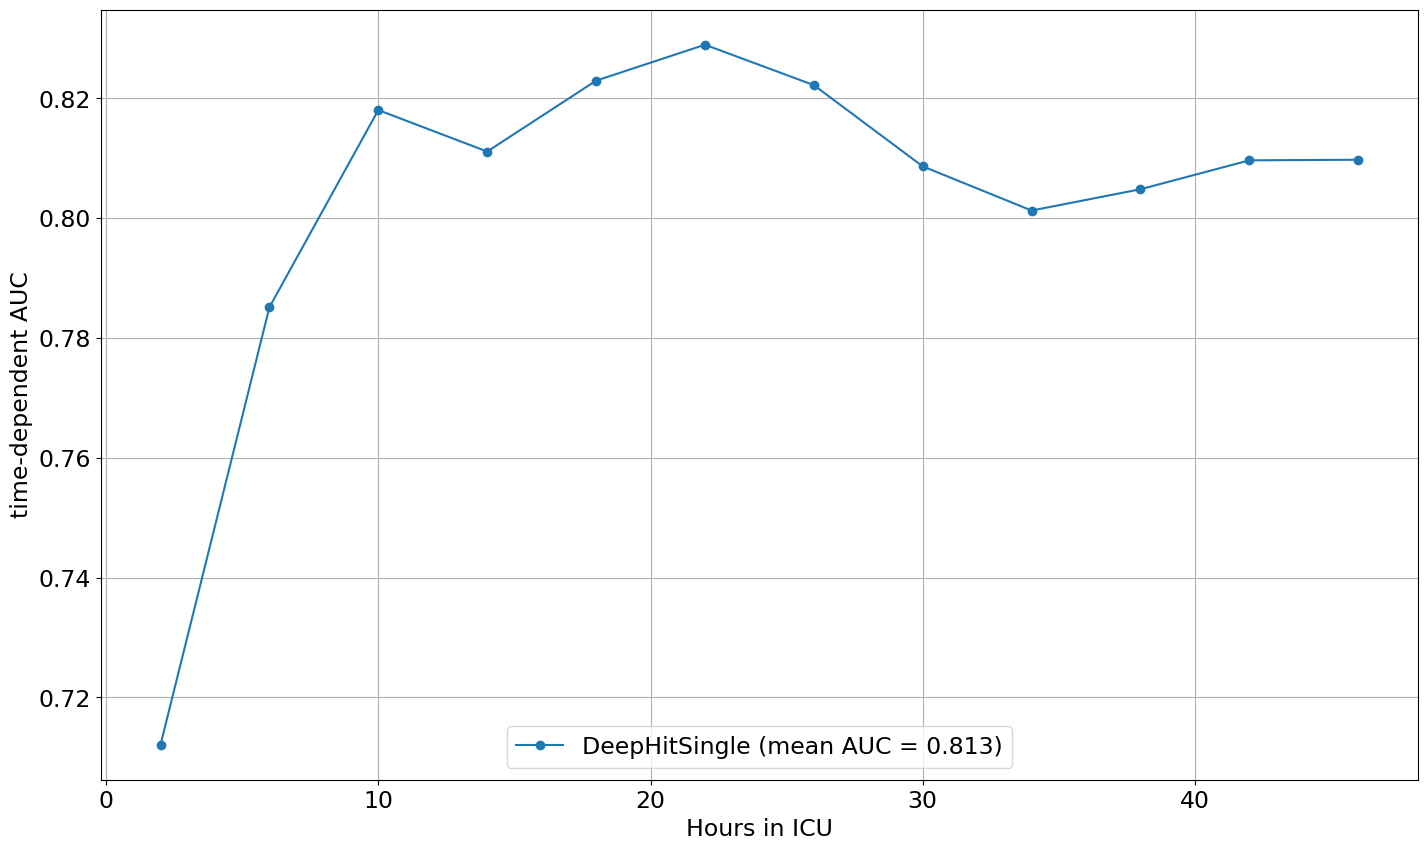

In [477]:
plt.plot(va_times, DeepHitSingle_auc, "o-", label="DeepHitSingle (mean AUC = {:.3f})".format(DeepHitSingle_mean_auc))
plt.xlabel("Hours in ICU")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

# Random Survival Forest model sksurv

In [191]:
random_state = 20
y_train_rsf=y_train
y_test_rsf=y_test

y_train_rsf['output_rsf'] = np.where(y_train_rsf['output']==1, True, False)
y_train_rsf.head()
y_train_rsf=y_train_rsf[['output_rsf', 'time_to_aki_hr']]
print(y_train_rsf.to_records(index=False))
print(y_train_rsf)

y_test_rsf['output_rsf'] = np.where(y_test_rsf['output']==1, True, False)
y_test_rsf.head()
y_test_rsf=y_test_rsf[['output_rsf', 'time_to_aki_hr']]

[( True,  3.35      ) (False, 96.        ) (False, 96.        ) ...
 ( True, 15.71666667) (False, 96.        ) (False, 96.        )]
       output_rsf  time_to_aki_hr
0            True        3.350000
2           False       96.000000
5           False       96.000000
6            True        6.333333
7           False       96.000000
...           ...             ...
21155       False       96.000000
21157       False       96.000000
21159        True       15.716667
21160       False       96.000000
21162       False       96.000000

[13545 rows x 2 columns]


In [234]:
num_trees=[100,200,300,400,500,600]
mean_auc_numtree=[]

In [235]:
for i in num_trees:
    print(i)
    rsf = RandomSurvivalForest(n_estimators=i,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
    rsf.fit(x_train, y_train_rsf.to_records(index=False))
    
    rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    x_test, return_array=False)
    rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

    
    rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train_rsf.to_records(index=False), y_test_rsf.to_records(index=False), rsf_risk_scores, va_times)
    
    mean_auc_numtree.append(rsf_mean_auc)

500
600


In [237]:
#500,600
#num_tree_500_600=mean_auc_numtree
num_tree_500_600

[0.8172846337396868, 0.8171791329535074]

In [238]:
#300, 400
#num_tree_300_400=mean_auc_numtree
num_tree_300_400

[0.8175235491850497, 0.8172324553679593]

In [239]:
#100,200
#num_tree_100_200=mean_auc_numtree
num_tree_100_200

[0.8162904300058854, 0.8173775413995866]

In [241]:
#parameter tuning result
mean_auc_num_tree_100to600=[num_tree_100_200,num_tree_300_400, num_tree_500_600]
mean_auc_num_tree_100to600

[[0.8162904300058854, 0.8173775413995866],
 [0.8175235491850497, 0.8172324553679593],
 [0.8172846337396868, 0.8171791329535074]]

In [497]:
from itertools import chain
flatten_mean_100_to_600=list(chain.from_iterable(mean_auc_num_tree_100to600))

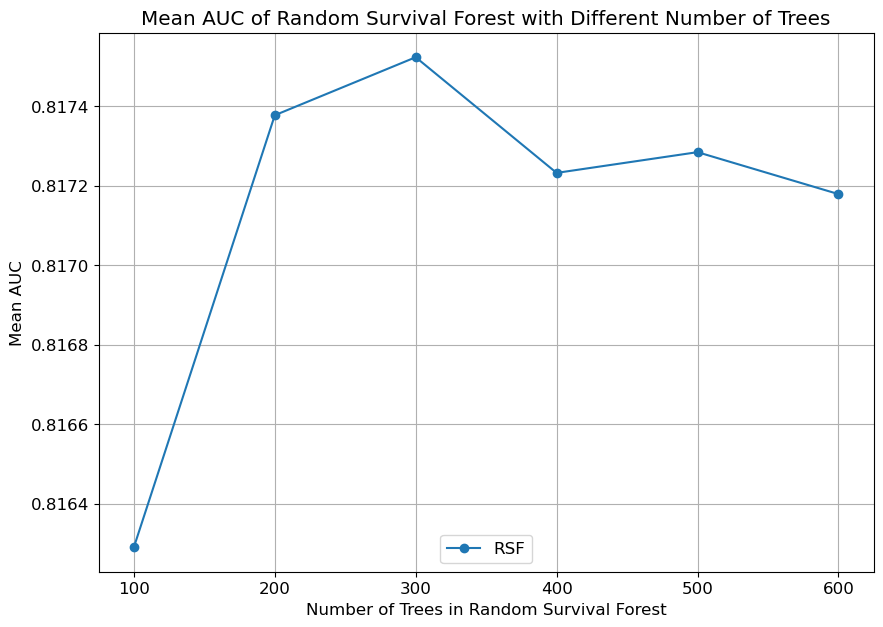

In [566]:
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 12})

num_of_tree=['100','200','300','400','500','600']

plt.plot(num_of_tree, flatten_mean_100_to_600, "o-", label="RSF")
# plt.ylim(0.816,0.818)
plt.xlabel("Number of Trees in Random Survival Forest")
plt.ylabel("Mean AUC")
plt.title('Mean AUC of Random Survival Forest with Different Number of Trees')
plt.legend(loc="lower center")
plt.grid(True)

In [192]:
rsf = RandomSurvivalForest(n_estimators=300,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(x_train, y_train_rsf.to_records(index=False))

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=300, n_jobs=-1,
                     random_state=20)

In [215]:
rsf.event_times_

array([1.66666667e-02, 3.33333333e-02, 5.00000000e-02, ...,
       4.79666667e+01, 4.79833333e+01, 4.80000000e+01])

In [209]:
#concordance index.
rsf.score(x_test, y_test_rsf.to_records(index=False))

0.7370455842888795

In [210]:
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    x_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train_rsf.to_records(index=False), y_test_rsf.to_records(index=False), rsf_risk_scores, va_times
)

In [215]:
rsf_surv_prob = np.row_stack([
    fn(va_times)
    for fn in rsf.predict_survival_function(x_test)
])
integrated_brier_score(y_train_rsf.to_records(index=False),y_test_rsf.to_records(index=False), rsf_surv_prob, va_times)

0.15012272064850823

In [224]:
cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(x_train, y_train_rsf.to_records(index=False))

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis())])

In [225]:
cph_risk_scores = cph.predict(x_test)
cph_auc_test, cph_mean_auc = cumulative_dynamic_auc(
    y_train_rsf.to_records(index=False), y_test_rsf.to_records(index=False), cph_risk_scores, va_times
)

In [226]:
#concordance index.
cph.score(x_test, y_test_rsf.to_records(index=False))

0.7172946735857488

In [227]:
cph_surv_prob = np.row_stack([
    fn(va_times)
    for fn in cph.predict_survival_function(x_test)
])
integrated_brier_score(y_train_rsf.to_records(index=False),y_test_rsf.to_records(index=False), cph_surv_prob, va_times)

0.15766294016772922

In [570]:
# plt.rcParams['figure.figsize'] = [10, 7]

# plt.plot(va_times, cph_auc_test, "o-", label="CoxPH (mean AUC = {:.3f})".format(cph_mean_auc))
# plt.plot(va_times, rsf_auc, "o-", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
# plt.plot(va_times, logisticHazard_auc, "o-", label="LogHazard (mean AUC = {:.3f})".format(logisticHazard_mean_auc))
# plt.plot(va_times, DeepHitSingle_auc, "o-", label="DeepHitSingle (mean AUC = {:.3f})".format(DeepHitSingle_mean_auc))
# plt.xlabel("Hours in ICU")
# plt.ylabel("time-dependent AUC")
# plt.legend(loc="lower center")
# plt.grid(True)

# 10 Fold Cross Validation

In [44]:
def XY_transform_LogisticHazard(x_train, x_test, x_val, y_train, y_test, y_val):
    num_durations = 10
    from pycox.models import LogisticHazard

    labtrans = LogisticHazard.label_transform(num_durations)

    get_target = lambda df: (df['time_to_aki_hr'].values, df['output'].values)

    y_train_transform = labtrans.fit_transform(*get_target(y_train))
    y_test_transform=labtrans.transform(*get_target(y_test))
    y_val_transform=labtrans.transform(*get_target(y_val))

    x_train_float=x_train.astype('float32')
    x_val_float=x_val.astype('float32')
    x_test_float=x_test.astype('float32')
    #x_train_np=x_train.to_numpy()
    
    return (x_train_float, x_test_float, x_val_float, y_train_transform, y_test_transform, y_val_transform, labtrans)



In [45]:
def XY_transform_DeepHitSingle(x_train, x_test, x_val, y_train, y_test, y_val):
    num_durations = 10
    from pycox.models import DeepHitSingle

    labtrans = DeepHitSingle.label_transform(num_durations)

    get_target = lambda df: (df['time_to_aki_hr'].values, df['output'].values)

    y_train_transform = labtrans.fit_transform(*get_target(y_train))
    y_test_transform=labtrans.transform(*get_target(y_test))
    y_val_transform=labtrans.transform(*get_target(y_val))

    x_train_float=x_train.astype('float32')
    x_val_float=x_val.astype('float32')
    x_test_float=x_test.astype('float32')
    #x_train_np=x_train.to_numpy()
    
    return (x_train_float, x_test_float, x_val_float, y_train_transform, y_test_transform, y_val_transform, labtrans)


In [46]:
def XY_transform_RSF(y_train, y_test):
    random_state = 20
    y_train_rsf=y_train
    y_test_rsf=y_test

    y_train_rsf['output_rsf'] = np.where(y_train_rsf['output']==1, True, False)
    y_train_rsf.head()
    y_train_rsf=y_train_rsf[['output_rsf', 'time_to_aki_hr']]
    #print(y_train_rsf.to_records(index=False))
    #print(y_train_rsf)

    y_test_rsf['output_rsf'] = np.where(y_test_rsf['output']==1, True, False)
    y_test_rsf.head()
    y_test_rsf=y_test_rsf[['output_rsf', 'time_to_aki_hr']]
    
    return (y_train_rsf, y_test_rsf)

In [47]:
batch_size = 256
epochs = 100
va_times = np.arange(2, 50, 4)
random_state = 20

In [533]:
def LogisticHazard_Model_Result(x_train_fold_LogH, y_train_fold_LogH,val,x_test_fold_LogH,y_test_fold, labtrans, y_train_fr_plot, y_test_fr_plot):
    nn_64_32_6layer.apply(weight_reset)
    model_logisticHazard = LogisticHazard(nn_64_32_6layer, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
    callbacks = [tt.cb.EarlyStopping()]
    
    #find the best learning rate
    lrfinder = model_logisticHazard.lr_finder(x_train_fold_LogH.to_numpy(), y_train_fold_LogH, batch_size, tolerance=2)
    #_ = lrfinder.plot()
    lr_best=lrfinder.get_best_lr()
    # to prevent using a learning rate larger than 0.01
    if lr_best>0.01:
        model_logisticHazard.optimizer.set_lr(0.01)
    else:
        model_logisticHazard.optimizer.set_lr(lr_best)

    model_logisticHazard.fit(x_train_fold_LogH.to_numpy(), y_train_fold_LogH, batch_size, epochs, callbacks,val_data=val)

    surv_logisticHazard = model_logisticHazard.predict_surv_df(x_test_fold_LogH.to_numpy())

    durations_test=y_test_fold['time_to_aki_hr'].to_numpy()
    events_test=y_test_fold['output'].to_numpy()
    ev_logisticHazard = EvalSurv(surv_logisticHazard, durations_test, events_test, censor_surv='km')
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

    brier=ev_logisticHazard.integrated_brier_score(time_grid) 
    
    row_index_logisticHazard=np.asarray(surv_logisticHazard.index)
    cumulative_hazard_LogisticHazard=-np.log(surv_logisticHazard)

    step_functions=list()

    for i in range(0,cumulative_hazard_LogisticHazard.shape[1]):

        stpfun=sksurv.functions.StepFunction(row_index_logisticHazard, np.asarray(cumulative_hazard_LogisticHazard.iloc[:,i]), a=1.0, b=0.0)
        step_functions.append(stpfun)

    #risk_score=stpfun(va_times)
    logisticHazard_risk_scores = np.row_stack([chf(va_times) for chf in step_functions])

    logisticHazard_auc, logisticHazard_mean_auc = cumulative_dynamic_auc(
        y_train_fr_plot.to_records(index=False), y_test_fr_plot.to_records(index=False), logisticHazard_risk_scores, va_times
    )
    
    return (brier, logisticHazard_auc, logisticHazard_mean_auc)

In [534]:
def DeepHS_Model_Result(x_train_fold_DeepHS, y_train_fold_DeepHS,val,x_test_fold_DeepHS,y_test_fold, labtrans, y_train_fr_plot, y_test_fr_plot):
    from pycox.models import DeepHitSingle
    nn_32_4layer.apply(weight_reset)
    model_DeepHS = DeepHitSingle(nn_32_4layer, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
    callbacks = [tt.cb.EarlyStopping()]

    model_DeepHS.fit(x_train_fold_DeepHS.to_numpy(), y_train_fold_DeepHS, batch_size, epochs, callbacks, val_data=val)
    surv_DeepHitSingle = model_DeepHS.predict_surv_df(x_test_fold_DeepHS.to_numpy())

    durations_test=y_test_fold['time_to_aki_hr'].to_numpy()
    events_test=y_test_fold['output'].to_numpy()
    ev_DeepHitSingle = EvalSurv(surv_DeepHitSingle, durations_test, events_test, censor_surv='km')
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

    brier=ev_DeepHitSingle.integrated_brier_score(time_grid) 
    
    row_index_DeepHitSingle=np.asarray(surv_DeepHitSingle.index)
    cumulative_hazard_DeepHitSingle=-np.log(surv_DeepHitSingle)

    step_functions=list()

    for i in range(0,cumulative_hazard_DeepHitSingle.shape[1]):

        stpfun=sksurv.functions.StepFunction(row_index_DeepHitSingle, np.asarray(cumulative_hazard_DeepHitSingle.iloc[:,i]), a=1.0, b=0.0)
        step_functions.append(stpfun)

    #risk_score=stpfun(va_times)
    DeepHitSingle_risk_scores = np.row_stack([chf(va_times) for chf in step_functions])
    DeepHitSingle_auc, DeepHitSingle_mean_auc = cumulative_dynamic_auc(
        y_train_fr_plot.to_records(index=False), y_test_fr_plot.to_records(index=False), DeepHitSingle_risk_scores, va_times
    )
    
    return (brier, DeepHitSingle_auc, DeepHitSingle_mean_auc)

In [58]:
def RSF_Model_Result(x_train_fold, x_test_fold, y_train_rsf, y_test_rsf):
    rsf = RandomSurvivalForest(n_estimators=300,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
    rsf.fit(x_train_fold, y_train_rsf.to_records(index=False))
    rsf_surv_prob = np.row_stack([fn(va_times)for fn in rsf.predict_survival_function(x_test_fold)])
    brier=integrated_brier_score(y_train_rsf.to_records(index=False),y_test_rsf.to_records(index=False), rsf_surv_prob, va_times)
    
    rsf_chf_funcs = rsf.predict_cumulative_hazard_function(x_test_fold, return_array=False)
    rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

    rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
        y_train_rsf.to_records(index=False), y_test_rsf.to_records(index=False), rsf_risk_scores, va_times
    )
    
    return (brier, rsf_auc, rsf_mean_auc)

In [68]:
def CoxPH_Model_Result(x_train_fold, x_test_fold, y_train_rsf, y_test_rsf):
    cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
    cph.fit(x_train_fold, y_train_rsf.to_records(index=False))
    cph_risk_scores = cph.predict(x_test_fold)

    
    cph_surv_prob = np.row_stack([fn(va_times) for fn in cph.predict_survival_function(x_test_fold)])
    brier=integrated_brier_score(y_train_rsf.to_records(index=False),y_test_rsf.to_records(index=False), cph_surv_prob, va_times)
    
    cph_auc, cph_mean_auc = cumulative_dynamic_auc(
        y_train_rsf.to_records(index=False), y_test_rsf.to_records(index=False), cph_risk_scores, va_times
    )
    
    return (brier, cph_auc, cph_mean_auc)

In [ ]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits=10) 
kf.get_n_splits(X_reduced_std) 
iterate through train and test folds
LogisticHazard_brierScore=list()
CoxPH_brierScore=list()
RandomSF_brierScore=list()
DeepHitSingle_brierScore=list()

LogisticHazard_auc=list()
CoxPH_auc=list()
RandomSF_auc=list()
DeepHitSingle_auc=list()

LogisticHazard_mean_auc=list()
CoxPH_mean_auc=list()
RandomSF_mean_auc=list()
DeepHitSingle_mean_auc=list()

for train_index, test_index in kf.split(X_reduced_std):
    
    val_index=train_index[0:int(len(train_index)*0.2)]
    train_index_rm= train_index[int(len(train_index)*0.2):len(train_index)]
    
    x_train_fold, x_test_fold, x_val_fold = X_reduced_std.iloc[train_index_rm,:], X_reduced_std.iloc[test_index,:], X_reduced_std.iloc[val_index,:]
    y_train_fold, y_test_fold, y_val_fold = Y_orig_df.iloc[train_index_rm,:], Y_orig_df.iloc[test_index,:], Y_orig_df.iloc[val_index,:]
    
    
    y_train_fr_plot=y_train_fold
    y_test_fr_plot=y_test_fold

    y_train_fr_plot['output_TF']=np.where(y_train_fr_plot['output']==1, True, False)
    y_test_fr_plot['output_TF']=np.where(y_test_fr_plot['output']==1, True, False)

    y_train_fr_plot_cv=y_train_fr_plot[['output_TF', 'time_to_aki_hr']]
    y_test_fr_plot_cv=y_test_fr_plot[['output_TF', 'time_to_aki_hr']]

    #Logistic Hazard:
    x_train_fold_LogH, x_test_fold_LogH, x_val_fold_LogH, y_train_fold_LogH, y_test_fold_LogH, y_val_fold_LogH, labtrans_LogH=XY_transform_LogisticHazard(x_train_fold, x_test_fold, x_val_fold, y_train_fold, y_test_fold, y_val_fold)
    val_fold_LogH=(x_val_fold_LogH.to_numpy(), y_val_fold_LogH)

    brier_LogH, logisticHazard_auc, logisticHazard_mean_auc=LogisticHazard_Model_Result(x_train_fold_LogH, y_train_fold_LogH,val_fold_LogH, x_test_fold_LogH,y_test_fold, labtrans_LogH,y_train_fr_plot_cv, y_test_fr_plot_cv  )
    LogisticHazard_brierScore.append(brier_LogH)
    LogisticHazard_auc.append(logisticHazard_auc)
    LogisticHazard_mean_auc.append(logisticHazard_mean_auc)
    

    #DeepHit Single Event:
    x_train_fold_DeepHS, x_test_fold_DeepHS, x_val_fold_DeepHS, y_train_fold_DeepHS, y_test_fold_DeepHS, y_val_fold_DeepHS, labtrans_DeepHS=XY_transform_DeepHitSingle(x_train_fold, x_test_fold, x_val_fold, y_train_fold, y_test_fold, y_val_fold)
    val_fold_DeepHS=(x_val_fold_DeepHS.to_numpy(), y_val_fold_DeepHS)

    brier_DeepHS, DeepHS_auc, DeepHS_mean_auc=DeepHS_Model_Result(x_train_fold_DeepHS, y_train_fold_DeepHS,val_fold_DeepHS,x_test_fold_DeepHS,y_test_fold, labtrans_DeepHS, y_train_fr_plot_cv, y_test_fr_plot_cv )
    DeepHitSingle_brierScore.append(brier_DeepHS)
    DeepHitSingle_auc.append(DeepHS_auc)
    DeepHitSingle_mean_auc.append(DeepHS_mean_auc)
    
    #Random Survival Forest
    y_train_rsf, y_test_rsf=XY_transform_RSF(y_train_fold, y_test_fold)
    
    brier_RSF, RSF_auc, RSF_mean_auc=RSF_Model_Result(x_train_fold, x_test_fold, y_train_rsf, y_test_rsf)
    RandomSF_brierScore.append(brier_RSF)
    RandomSF_auc.append(RSF_auc)
    RandomSF_mean_auc.append(RSF_mean_auc)
    
    #Cox Porportional Hazard
    brier_cph, cph_auc, cph_mean_auc=CoxPH_Model_Result(x_train_fold,x_test_fold, y_train_rsf, y_test_rsf)
    CoxPH_brierScore.append(brier_cph)
    CoxPH_auc.append(cph_auc)
    CoxPH_mean_auc.append(cph_mean_auc)




In [536]:
print(sum(LogisticHazard_brierScore)/len(LogisticHazard_brierScore))
print(sum(CoxPH_brierScore)/len(CoxPH_brierScore))
print(sum(RandomSF_brierScore)/len(RandomSF_brierScore))
print(sum(DeepHitSingle_brierScore)/len(DeepHitSingle_brierScore))

0.1755392897348366


In [567]:
#plot for Brier Score

zipped = list(zip(LogisticHazard_brierScore,  RandomSF_brierScore, DeepHitSingle_brierScore))
performance_df=pd.DataFrame(zipped, columns=['LogisticHazard', 'RandomSurvivalForest','DeepHit'])
performance_df

import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

import plotly.graph_objects as go
folds=['1', '2', '3','4','5','6','7','8','9','10']

fig = go.Figure(data=[
    go.Bar(name='LogisticHazard', x=folds, y=LogisticHazard_brierScore),
    #go.Bar(name='CoxPH (mean brier score=0.156)', x=folds, y=CoxPH_brierScore),
    go.Bar(name='RandomSurvivalForest', x=folds, y=RandomSF_brierScore),
    go.Bar(name='DeepHit', x=folds, y=DeepHitSingle_brierScore)
    
])
# Change the bar mode
fig.update_layout(barmode='group',
    title="10-Fold Cross Validation",
    xaxis_title="Fold",
    yaxis_title="Brier Score",
    legend_title="Model Applied",)
fig.show()

In [545]:
# LogisticHazard_auc_df=pd.DataFrame(LogisticHazard_auc)
# foldCV_LogisticHazard_auc_mean=LogisticHazard_auc_df.mean(axis=0)
# mean_overall_LogisticHazard=sum(foldCV_LogisticHazard_auc_mean)/len(foldCV_LogisticHazard_auc_mean)

DeepHitSingle_auc_df=pd.DataFrame(DeepHitSingle_auc)
foldCV_DeepHitSingle_auc_mean=DeepHitSingle_auc_df.mean(axis=0)
mean_overall_DeepHitSingle=sum(foldCV_DeepHitSingle_auc_mean)/len(foldCV_DeepHitSingle_auc_mean)

# RandomSF_auc_df=pd.DataFrame(RandomSF_auc)
# foldCV_RandomSF_auc_mean=RandomSF_auc_df.mean(axis=0)
# mean_overall_RandomSF=sum(foldCV_RandomSF_auc_mean)/len(foldCV_RandomSF_auc_mean)

# CoxPH_auc_df=pd.DataFrame(CoxPH_auc)
# foldCV_CoxPH_auc_mean=CoxPH_auc_df.mean(axis=0)
# mean_overall_CoxPH=sum(foldCV_CoxPH_auc_mean)/len(foldCV_CoxPH_auc_mean)


In [528]:
cox_fold_save=foldCV_CoxPH_auc_mean
rsf_fold_save=foldCV_RandomSF_auc_mean
loghazard_fold_save=foldCV_LogisticHazard_auc_mean
deephit_fold_save=foldCV_DeepHitSingle_auc_mean

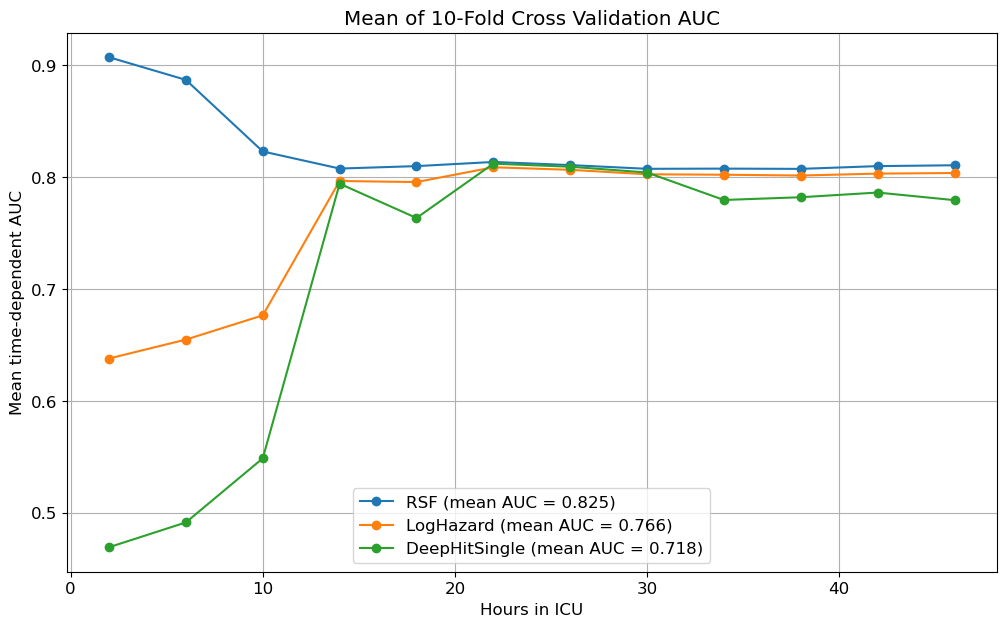

In [558]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams.update({'font.size': 12})

#plt.plot(va_times, foldCV_CoxPH_auc_mean, "o-", label="CoxPH (mean AUC = {:.3f})".format(mean_overall_CoxPH))
plt.plot(va_times, foldCV_RandomSF_auc_mean, "o-", label="RSF (mean AUC = {:.3f})".format(mean_overall_RandomSF))
plt.plot(va_times, foldCV_LogisticHazard_auc_mean, "o-", label="LogHazard (mean AUC = {:.3f})".format(mean_overall_LogisticHazard))
plt.plot(va_times, foldCV_DeepHitSingle_auc_mean, "o-", label="DeepHitSingle (mean AUC = {:.3f})".format(mean_overall_DeepHitSingle))
plt.xlabel("Hours in ICU")
plt.ylabel("Mean time-dependent AUC")
plt.legend(loc="lower center")
plt.title('Mean of 10-Fold Cross Validation AUC')
plt.grid(True)
plt.savefig('/Users/xueying/Downloads/SPH6004/Assignment 2 question (group assi/AUC_allmodels_10fold.png')